In [1]:
! pip install pm4py
! pip install seaborn

You should consider upgrading via the 'c:\users\pc\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\pc\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [2]:
import pm4py
import pandas as pd
import datetime
from math import ceil
import matplotlib.pyplot as plt
import numpy as np
from importlib import reload
import random
import seaborn as sns
from IPython import display

# What is it about
## Data
We have data of processes - `bpi12`. It is a sequence of (`time_stamp`, `activity`,...) 
and other stuff which is not considered by community. Basicly here it is `BPI_Challenge_2012.xes`

In [3]:
file_path = 'datasets/BPI_Challenge_2012.xes'
event_log = pm4py.read_xes(file_path)
df = pm4py.convert_to_dataframe(event_log)
df

,org:resource,lifecycle:transition,concept:name,time:timestamp,case:REG_DATE,case:concept:name,case:AMOUNT_REQ
0,112,COMPLETE,A_SUBMITTED,2011-10-01 00:38:44.546000+02:00,2011-10-01 00:38:44.546000+02:00,173688,20000
1,112,COMPLETE,A_PARTLYSUBMITTED,2011-10-01 00:38:44.880000+02:00,2011-10-01 00:38:44.546000+02:00,173688,20000
2,112,COMPLETE,A_PREACCEPTED,2011-10-01 00:39:37.906000+02:00,2011-10-01 00:38:44.546000+02:00,173688,20000
3,112,SCHEDULE,W_Completeren aanvraag,2011-10-01 00:39:38.875000+02:00,2011-10-01 00:38:44.546000+02:00,173688,20000
4,NaN,START,W_Completeren aanvraag,2011-10-01 11:36:46.437000+02:00,2011-10-01 00:38:44.546000+02:00,173688,20000
...,...,...,...,...,...,...,...
262195,112,COMPLETE,A_PARTLYSUBMITTED,2012-02-29 23:51:17.423000+01:00,2012-02-29 23:51:16.799000+01:00,214376,15000
262196,112,SCHEDULE,W_Afhandelen leads,2012-02-29 23:52:01.287000+01:00,2012-02-29 23:51:16.799000+01:00,214376,15000
262197,11169,START,W_Afhandelen leads,2012-03-01 09:26:46.736000+01:00,2012-02-29 23:51:16.799000+01:00,214376,15000
262198,11169,COMPLETE,A_DECLINED,2012-03-01 09:27:37.118000+01:00,2012-02-29 23:51:16.799000+01:00,214376,15000


We works only wuith activity (which is about completion of process) and time

In [4]:
df = pm4py.convert_to_dataframe(event_log)
df = df[df['lifecycle:transition']=='COMPLETE']
# work subprocess, starts with 'W_'
is_work_sp = df['concept:name'].apply(lambda x: True if x[:2] == 'W_' else False)
df = df[is_work_sp]

df = df[['time:timestamp', 'case:concept:name', 'concept:name']]
df = df.rename(columns={'time:timestamp': 'timestamp', 'case:concept:name': 'trace_id', 'concept:name': 'activity'})

In [5]:
taces_with_nans = []
traces = set(df['trace_id'].values)
l = len(traces)
for _i, t_id in enumerate(traces):
    if df[df['trace_id'] == t_id].isna().sum().sum() > 0:
        taces_with_nans.append(t_id)

In [6]:
len(taces_with_nans)

0

In [7]:
df['trace_id'] = df['trace_id'].apply(lambda x: int(x))
df.reset_index(inplace=True)
df.drop(columns='index', inplace=True)
df.to_csv('datasets/bpi_12.csv', index=False)
df

,timestamp,trace_id,activity
0,2011-10-01 11:45:13.917000+02:00,173688,W_Completeren aanvraag
1,2011-10-01 12:17:08.924000+02:00,173688,W_Nabellen offertes
2,2011-10-08 16:32:00.886000+02:00,173688,W_Nabellen offertes
3,2011-10-10 11:33:05.791000+02:00,173688,W_Nabellen offertes
4,2011-10-13 10:37:37.026000+02:00,173688,W_Valideren aanvraag
...,...,...,...
72408,2012-03-01 09:28:21.228000+01:00,214370,W_Afhandelen leads
72409,2012-03-01 09:27:52.388000+01:00,214373,W_Afhandelen leads
72410,2012-03-01 20:22:41.157000+01:00,214373,W_Completeren aanvraag
72411,2012-03-10 12:50:54.881000+01:00,214373,W_Nabellen offertes


Some defenitions must be mentioned:
- event ($e_i$) - {`activity` ($a$), `time_stamp` ($t$)}
- trace (t) - $[e_1,\ e_2, \dots]$

## Purpose
Main objective - predict next `time_stamp` and `activity`. 

For activity metric, used by community is accuracy, and in latest works `f1`. For `time_stamp` ussualy MAE, sometimes weighted MAE.

Nevetheless some other objectives are discovered - whole trace prediction. The metric for activity prediction - Damerau-Levenshtein Similarity

# Visualization
## Activity transition
Firstly let's take a look on all activities transition  and try to estimate $P(a_{i+1} | a_i)$. It is a square matrix, which worth to be presented as `sns.heatmap`

In [8]:
activities = list(set(df['activity'].values))
n_act = len(activities)
traces = list(set(df['trace_id'].values))
_df = df.copy()
_df['activity_prev'] = _df['activity'].shift(1)
_df['trace_id_prev'] = _df['trace_id'].shift(1)
_df = _df.dropna()
_df = _df[_df['trace_id_prev'] == _df['trace_id']]

In [9]:

transitions_counts = np.zeros((n_act, n_act))
nums_of_ac_next = []
for _i_next, act_next in enumerate(activities):
    _df_ac_next = _df[_df['activity'] == act_next]
    nums_of_ac_next.append(_df_ac_next.shape[0])
    for _i_prev, act_prev in enumerate(activities):
        transitions_counts[ _i_prev, _i_next] += _df_ac_next[_df_ac_next['activity_prev'] == act_prev].shape[0]

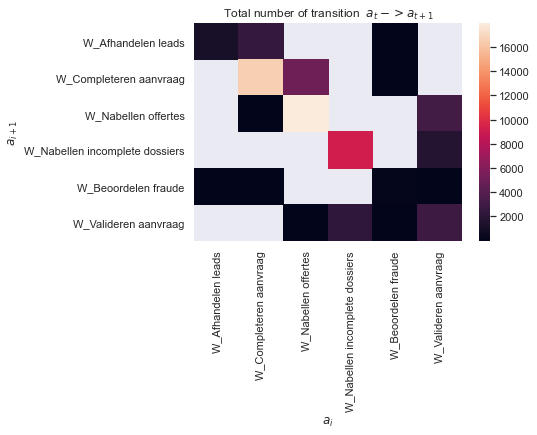

In [10]:
transitions_counts[transitions_counts == 0] = np.nan
sns.set(rc={'figure.facecolor':'white'})
sns.heatmap(transitions_counts, xticklabels=list(activities), yticklabels=list(activities))
plt.title('Total number of transition  $a_t -> a_{t+1}$')

plt.xlabel('$a_i$')
plt.ylabel('$a_{i+1}$')
plt.show()

In [11]:
print(f'There are {np.isnan(transitions_counts).sum()} not existing transitions')

There are 17 not existing transitions


In [12]:
transitions_counts[transitions_counts < 10] = np.nan

<ipython-input-12-6ef5bc085097>:1: RuntimeWarning: invalid value encountered in less
  transitions_counts[transitions_counts < 10] = np.nan


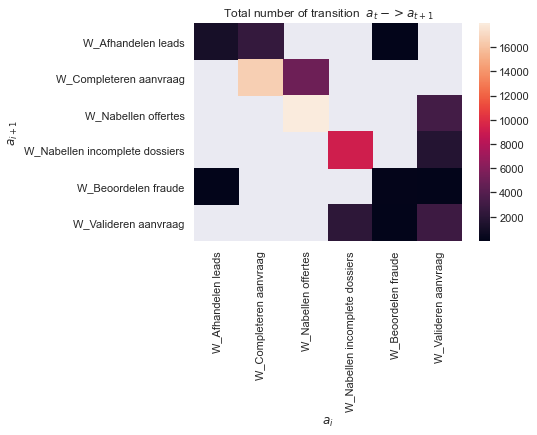

In [13]:
sns.set(rc={'figure.facecolor':'white'})
sns.heatmap(transitions_counts
            , xticklabels=list(activities), yticklabels=list(activities))
plt.title('Total number of transition  $a_t -> a_{t+1}$')

plt.xlabel('$a_i$')
plt.ylabel('$a_{i+1}$')
plt.show()

In [14]:
print(f'There are {np.isnan(transitions_counts).sum()} not existing transitions')

There are 21 not existing transitions


Cant say there are much rare transitions

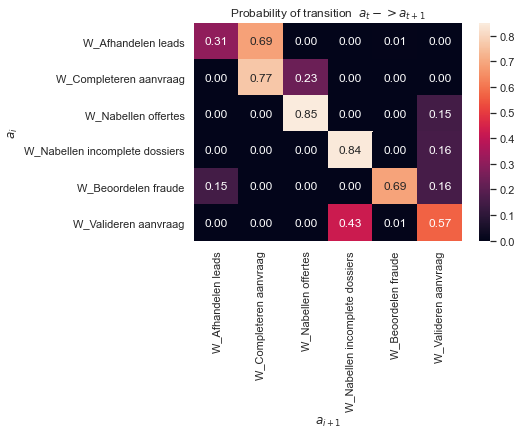

In [15]:
prob_matrix = transitions_counts / np.nan_to_num(transitions_counts, 0).sum(axis=1).reshape(-1, 1)
sns.set(rc={'figure.facecolor':'white'})
sns.heatmap(prob_matrix,
            xticklabels=list(activities), yticklabels=list(activities), 
            annot=True, fmt=".2f"
           )
plt.title('Probability of transition  $a_t -> a_{t+1}$')
plt.xlabel('$a_{i+1}$')
plt.ylabel('$a_i$')
plt.show()

In [16]:
filled = np.nan_to_num(transitions_counts, 0)
print(f'dull baseline {np.diagonal(filled).sum() / filled.sum()}')

dull baseline 0.7644911945174915


Can't say this dataset has uniform distribution.

## Time features
For leveraging predictive models the following features are created:
- $t_e$ - time since previous event
- $t_w$ - time since the beginning of week
- $t_t$ - time since the beginning of trace

let's visualize all these features

In [17]:
df

,timestamp,trace_id,activity
0,2011-10-01 11:45:13.917000+02:00,173688,W_Completeren aanvraag
1,2011-10-01 12:17:08.924000+02:00,173688,W_Nabellen offertes
2,2011-10-08 16:32:00.886000+02:00,173688,W_Nabellen offertes
3,2011-10-10 11:33:05.791000+02:00,173688,W_Nabellen offertes
4,2011-10-13 10:37:37.026000+02:00,173688,W_Valideren aanvraag
...,...,...,...
72408,2012-03-01 09:28:21.228000+01:00,214370,W_Afhandelen leads
72409,2012-03-01 09:27:52.388000+01:00,214373,W_Afhandelen leads
72410,2012-03-01 20:22:41.157000+01:00,214373,W_Completeren aanvraag
72411,2012-03-10 12:50:54.881000+01:00,214373,W_Nabellen offertes


In [18]:
import rl4pm_lib.preprocessing as preprocessing


prepro = preprocessing.DfPreprocesser()
prepro.fit(df)
df_preprocessed = prepro.transform(df)
df_preprocessed.to_csv('bpi_12_preprocessed.csv', index=False)

In [19]:
df_preprocessed

,tt,te,tw,timestamp,trace_id,W_Afhandelen leads,W_Beoordelen fraude,W_Completeren aanvraag,W_Nabellen incomplete dossiers,W_Nabellen offertes,W_Valideren aanvraag
0,0.000,0.000,474313.917,2011-10-01 11:45:13.917000+02:00,173688,0,0,1,0,0,0
1,1915.007,1915.007,476228.924,2011-10-01 12:17:08.924000+02:00,173688,0,0,0,0,1,0
2,622006.969,620091.962,491520.886,2011-10-08 16:32:00.886000+02:00,173688,0,0,0,0,1,0
3,776871.874,154864.905,41585.791,2011-10-10 11:33:05.791000+02:00,173688,0,0,0,0,1,0
4,1032743.109,255871.235,297457.026,2011-10-13 10:37:37.026000+02:00,173688,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
72408,0.000,0.000,293301.228,2012-03-01 09:28:21.228000+01:00,214370,1,0,0,0,0,0
72409,0.000,0.000,293272.388,2012-03-01 09:27:52.388000+01:00,214373,1,0,0,0,0,0
72410,39288.769,39288.769,332561.157,2012-03-01 20:22:41.157000+01:00,214373,0,0,1,0,0,0
72411,789782.493,750493.724,478254.881,2012-03-10 12:50:54.881000+01:00,214373,0,0,0,0,1,0


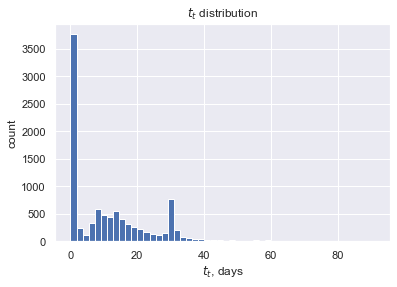

In [42]:
tts = []
for _tid in set(df_preprocessed['trace_id'].values):
    tts.append(df_preprocessed[df_preprocessed['trace_id']==_tid]['tt'].values[-1])
    
plt.hist(np.array(tts) / 3600 / 24, bins=50)
plt.title('$t_t$ distribution')
plt.xlabel('$t_t$, days')
plt.ylabel('count')
plt.show()

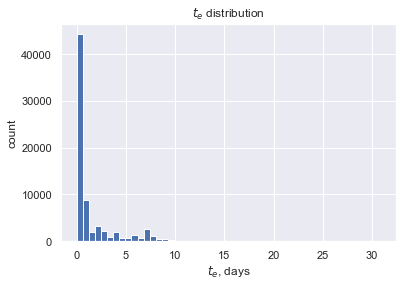

In [41]:
plt.hist(df_preprocessed['te'].values /3600 / 24, bins=50)
plt.title('$t_e$ distribution')
plt.xlabel('$t_e$, days')
plt.ylabel('count')
plt.show()

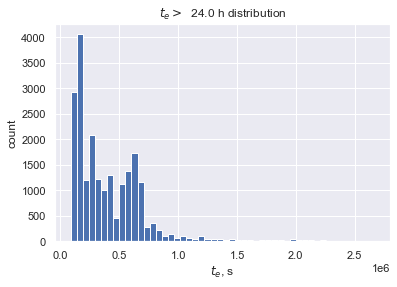

In [22]:
low_bond = 24 *  60 * 60
plt.hist(df_preprocessed[df_preprocessed['te'] > low_bond]['te'].values, bins=50)
plt.title(f'$t_e >$ {low_bond / 60 / 60: .1f} h distribution')
plt.xlabel('$t_e$, s')
plt.ylabel('count')
plt.show()

This distribution is far from uniform too

In [23]:
for quant in [0.9, 0.95, 0.97, 0.99]:
    print(f'{quant * 100} % of $te$ are less then {np.quantile(df_preprocessed["te"].values, quant) / (60 * 60): .2f} h')

90.0 % of $te$ are less then  140.73 h
95.0 % of $te$ are less then  173.25 h
97.0 % of $te$ are less then  193.57 h
99.0 % of $te$ are less then  307.72 h


## What is wrong with this visualization
- transition matrix has a lot of `nan`
- Whant to see which transitions lead to high $t_e$ 
### SberProcessMining
Let's use [this](https://github.com/SberProcessMining/Sber_Process_Mining) repo to got a nice visualization

In [24]:
! pip install sberpm

You should consider upgrading via the 'c:\users\pc\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [25]:
from sberpm import DataHolder

In [26]:
data_holder = DataHolder(data=df, 
                         id_column='trace_id', 
                         activity_column='activity', 
                         start_timestamp_column='timestamp')

c:\users\pc\appdata\local\programs\python\python38\lib\site-packages\sberpm\_holder.py:307: UserWarning: DataHolder: 'time_format' is not set, recommended to specify it for correct time conversion, e.g., time_format='%d-%m-%Y %H:%M:%S'
  warnings.warn("DataHolder: 'time_format' is not set, "
c:\users\pc\appdata\local\programs\python\python38\lib\site-packages\sberpm\_holder.py:339: UserWarning: DataHolder: timestamp auto conversion will be done. 'dayfirst' is not set, in ambiguous cases it will be considered as False.
  warnings.warn(f"DataHolder: timestamp auto conversion will be done. '{argument}' "
c:\users\pc\appdata\local\programs\python\python38\lib\site-packages\sberpm\_holder.py:339: UserWarning: DataHolder: timestamp auto conversion will be done. 'yearfirst' is not set, in ambiguous cases it will be considered as False.
  warnings.warn(f"DataHolder: timestamp auto conversion will be done. '{argument}' "


Strange warnings. It read all right, enven pandas can read datetime with no additional formats, so why does it nedd it, dunno

In [27]:
data_holder.data.head(3)

,timestamp,trace_id,activity
0,2011-10-01 09:45:13.917000+00:00,173688,W_Completeren aanvraag
1,2011-10-01 10:17:08.924000+00:00,173688,W_Nabellen offertes
2,2011-10-08 14:32:00.886000+00:00,173688,W_Nabellen offertes


In [28]:
from sberpm.autoinsights import AutoInsights
from sberpm.miners import SimpleMiner
from sberpm.visual import GraphvizPainter

the longest-lasting transitions are colored red

In [29]:
! pip install graphviz

You should consider upgrading via the 'c:\users\pc\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [30]:
auto_i = AutoInsights(data_holder, time_unit='day')
simple_miner = SimpleMiner(data_holder)
simple_miner.apply()
auto_i.apply(miner=simple_miner, mode='time')
graph = auto_i.get_graph()

painter = GraphvizPainter()
painter.apply_insights(graph)
painter.show()

all transitions are given a status:
- Optimal (positive insights)
- (negative insights)

In [31]:
auto_i = AutoInsights(data_holder, time_unit='day')
simple_miner = SimpleMiner(data_holder)
simple_miner.apply()
auto_i.apply(miner=simple_miner, mode='overall')
graph = auto_i.get_graph()

painter = GraphvizPainter()
painter.apply_insights(graph)
painter.show()

## Max $t_e$ & trace len

In [32]:
df_preprocessed

,tt,te,tw,timestamp,trace_id,W_Afhandelen leads,W_Beoordelen fraude,W_Completeren aanvraag,W_Nabellen incomplete dossiers,W_Nabellen offertes,W_Valideren aanvraag
0,0.000,0.000,474313.917,2011-10-01 11:45:13.917000+02:00,173688,0,0,1,0,0,0
1,1915.007,1915.007,476228.924,2011-10-01 12:17:08.924000+02:00,173688,0,0,0,0,1,0
2,622006.969,620091.962,491520.886,2011-10-08 16:32:00.886000+02:00,173688,0,0,0,0,1,0
3,776871.874,154864.905,41585.791,2011-10-10 11:33:05.791000+02:00,173688,0,0,0,0,1,0
4,1032743.109,255871.235,297457.026,2011-10-13 10:37:37.026000+02:00,173688,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
72408,0.000,0.000,293301.228,2012-03-01 09:28:21.228000+01:00,214370,1,0,0,0,0,0
72409,0.000,0.000,293272.388,2012-03-01 09:27:52.388000+01:00,214373,1,0,0,0,0,0
72410,39288.769,39288.769,332561.157,2012-03-01 20:22:41.157000+01:00,214373,0,0,1,0,0,0
72411,789782.493,750493.724,478254.881,2012-03-10 12:50:54.881000+01:00,214373,0,0,0,0,1,0


In [33]:
traces_te_max = {}
traces_len = {}
for t_id in set(df_preprocessed['trace_id'].values):
    _d = df_preprocessed[df_preprocessed['trace_id'] == t_id]
    traces_len[t_id] = _d.shape[0]
    traces_te_max[t_id] = _d['te'].max()

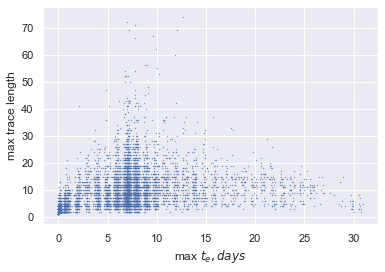

In [34]:
plt.scatter(np.array(list(traces_te_max.values())) / 3600 / 24, traces_len.values(), s=0.1)
plt.xlabel('max $t_e, days$')
plt.ylabel('max trace length')
plt.show()

# Loops
На рисунке были видны циклы.
Это плохо. Если мы использаем для обучения окна длиннйо 2, то возникает проблема:

$A \rightarrow B \rightarrow A \rightarrow B \rightarrow A \dots A \rightarrow B \rightarrow C$

сформируют признаки

$$[A,\ B],\ [A]$$
$$[B,\ A],\ [B]$$
$$[A,\ B],\ [A]$$
$$\dots$$

и не получится обучить что после $[A,\ B]$ идёт $[C]$

## Какие циклы?
Чтобы сильно не париться, будем искать циклы $A \rightarrow B \rightarrow A$. Отметим `trace_id` с циклами

In [35]:
from rl4pm_lib.preprocessing import is_there_cycle, number_of_cycles

In [36]:
assert is_there_cycle([1, 2, 3, 2]) == True
assert is_there_cycle([1, 2, 3]) == False
assert is_there_cycle([1, 2, 3, 3, 5, 6]) == True
assert is_there_cycle([1, 2, 3, 4, 5, 6]) == False

In [37]:
traces_is_cycle = {}
traces_num_cycles = {}
for t_id in set(df_preprocessed['trace_id'].values):
    _d = df[df['trace_id'] == t_id]
    traces_is_cycle[t_id] = is_there_cycle(_d['activity'].values)
    traces_num_cycles[t_id] = number_of_cycles(_d['activity'].values)

In [38]:
print(f'{np.array(list(traces_is_cycle.values())).sum() / len(traces_is_cycle) * 100: .2f}% of all traces got cycles')

 64.57% of all traces got cycles


Хотелось бы както это исправить

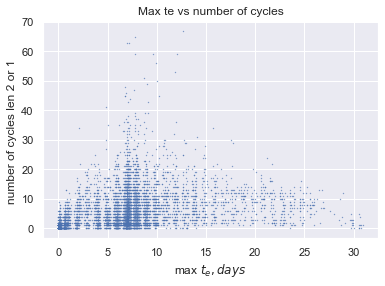

In [39]:
plt.scatter(np.array(list(traces_te_max.values())) / 3600 / 24, traces_num_cycles.values(), s=0.1)
plt.xlabel('max $t_e, days$')
plt.ylabel('number of cycles len 2 or 1 ')
plt.title('Max te vs number of cycles')
plt.show()

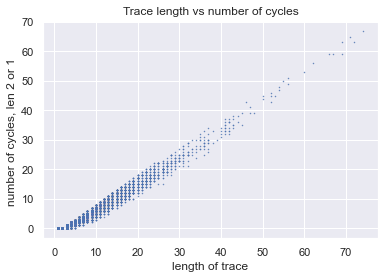

In [40]:
plt.scatter(list(traces_len.values()), traces_num_cycles.values(), s=0.2)
plt.xlabel('length of trace')
plt.ylabel('number of cycles, len 2 or 1 ')
plt.title('Trace length vs number of cycles')
plt.show()

тоесть если есть цикл, то он занимает $\frac{2}{3}$ процесса. Ужс